In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers
from keras.layers import LSTM, Dense, Bidirectional, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
# pd.set_option('display.max_rows', None)

In [3]:
train_data_path = '/content/drive/MyDrive/Carbon Dioxide Levels Prediction/train.csv'
test_data_path = '/content/drive/MyDrive/Carbon Dioxide Levels Prediction/test.csv'
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [ ]:
train_data.head()

In [ ]:
test_data.head()

## seperated the important collumns and filled the nan values with 0

In [4]:
train_data = train_data.drop(['Indicator','Unit'],axis=1)
test_data = test_data.drop(['Indicator','Unit'],axis=1)
train_data['Value'] = train_data['Value'].fillna(0)

<Axes: >

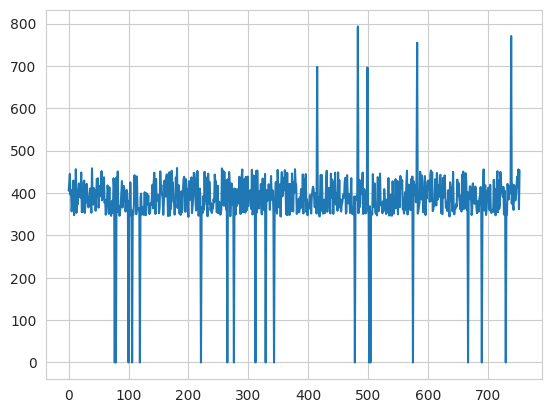

In [ ]:
train_data['Value'].plot()

## replaces outliers with the value 0

In [5]:
for i in range(len(train_data['Value'])):
  if train_data['Value'][i] > 600:
    train_data.loc[i, 'Value'] = 0

<Axes: >

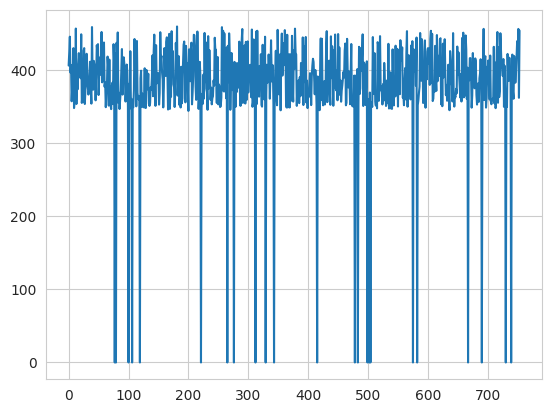

In [ ]:
train_data['Value'].plot()

## converted the 'Month' and 'Year' column into a 'Date' column

In [6]:
def to_date(data):
  data['Date'] = data['Year'].astype(str) + '-' + data['Month']
  data['Date'] = pd.to_datetime(data['Date'],format = "%Y-%B")
  data = data.drop(['Year','Month'],axis=1)
  return data

In [7]:
train_data = to_date(train_data)
train_data = train_data[['Date','Value']]
test_data = to_date(test_data)

In [8]:
train_data.head()

,Date,Value
0,2026-04-01,405.67
1,2035-07-01,423.20
2,2044-12-01,445.10
3,2023-01-01,396.04
4,2027-07-01,406.57


## sort by date
##### train_data -> train_2
##### test_data -> test_2

In [9]:
train_2 = train_data.sort_values(by=['Date'])
train_2.reset_index(drop=True,inplace=True)

test_2 = test_data #test data is already sorted

<Axes: >

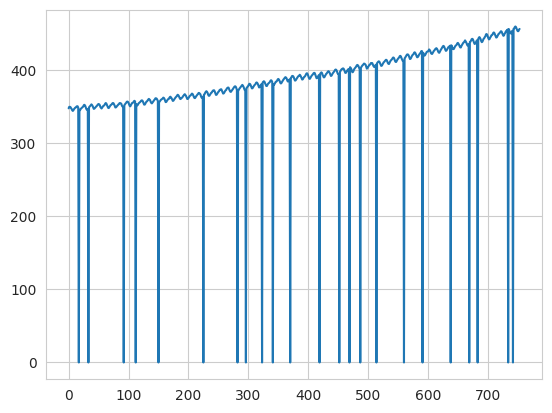

In [ ]:
train_2['Value'].plot()

## fill out the missing values with their neighbouring value avg

In [10]:
for i in range(len(train_2['Value'])):
  if train_2['Value'][i] == 0:
    replacement = (train_2['Value'][i-1] + train_2['Value'][i+1]) / 2
    train_2.loc[i,'Value'] = replacement

In [11]:
length = len(train_2['Value'])
length

754

<Axes: >

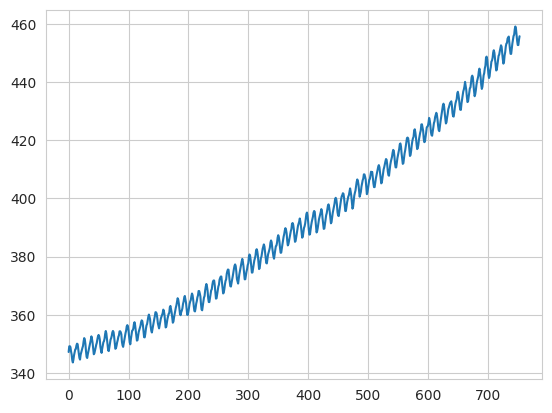

In [ ]:
train_2['Value'].plot()

28

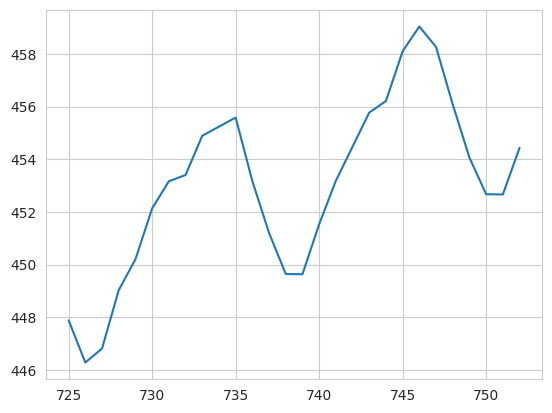

In [12]:
train_2['Value'][length-29:-1].plot()
len(train_2['Value'][length-29:-1])

##the graph seulting from the previous data augmentation method datalength 754 to 1400 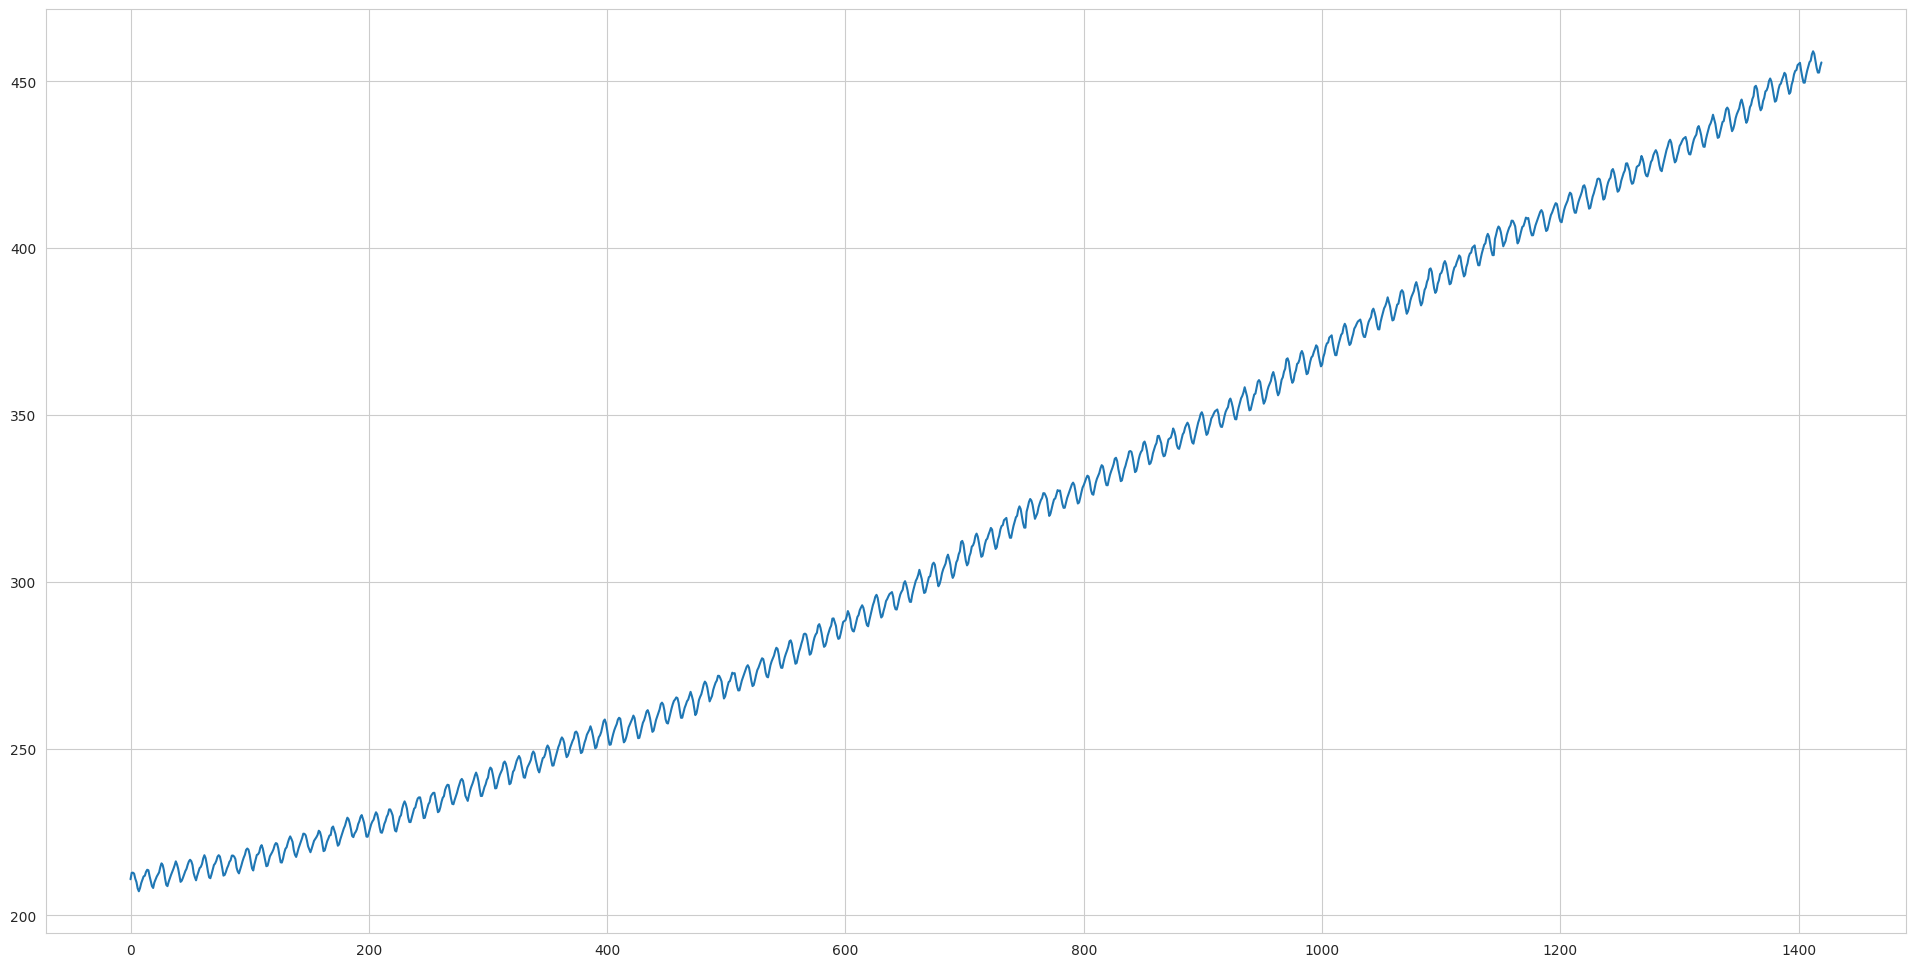

## distributing into cunks


### adding 28 target datas as one hill is 28 points long

##### s_train -> n_train
##### s_test -> n_test

In [13]:
train_2.pop('Date')
test_2.pop('Date')
train_2.head()

,Value
0,347.27
1,349.20
2,349.26
3,348.96
4,347.45


In [14]:
target = 26

In [15]:
def add_targets(data):
  new_data = data.iloc[target:,:].copy()
  for i in range(target-1,-1,-1):
    new_data[f'target -{i+1}'] = data['Value'].shift(i+1)

  return new_data


train_3 = add_targets(train_2)
train_3['Value'] = train_3.pop('Value')
test_3 = test_2
train_3.head()

,target -26,target -25,target -24,target -23,target -22,target -21,target -20,target -19,target -18,target -17,...,target -9,target -8,target -7,target -6,target -5,target -4,target -3,target -2,target -1,Value
26,347.27,349.20,349.26,348.96,347.45,346.42,344.52,343.67,344.66,346.14,...,346.705,345.22,344.66,346.29,347.14,348.07,348.68,349.34,350.93,352.04
27,349.20,349.26,348.96,347.45,346.42,344.52,343.67,344.66,346.14,347.14,...,345.220,344.66,346.29,347.14,348.07,348.68,349.34,350.93,352.04,351.55
28,349.26,348.96,347.45,346.42,344.52,343.67,344.66,346.14,347.14,348.13,...,344.660,346.29,347.14,348.07,348.68,349.34,350.93,352.04,351.55,350.00
29,348.96,347.45,346.42,344.52,343.67,344.66,346.14,347.14,348.13,348.32,...,346.290,347.14,348.07,348.68,349.34,350.93,352.04,351.55,350.00,347.49
30,347.45,346.42,344.52,343.67,344.66,346.14,347.14,348.13,348.32,349.49,...,347.140,348.07,348.68,349.34,350.93,352.04,351.55,350.00,347.49,345.59


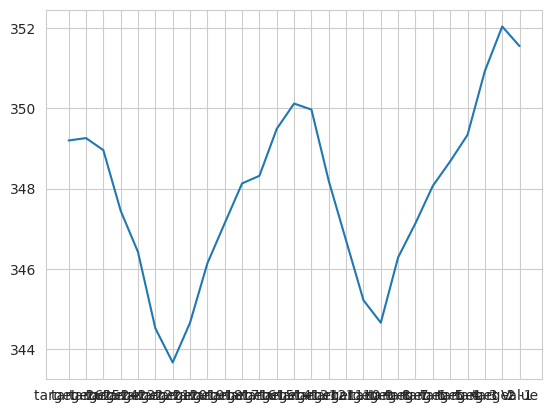

In [16]:
plt.plot(train_3.iloc[1])

# cut out unnecessary data

In [ ]:
# train_2[400:].plot()
# train_2.shape
# len(train_2[510:])

In [ ]:
# train_2[166:410].plot()
# train_2.shape

In [ ]:
# train_2[:166].plot()
# train_2.shape

# cut out the data

In [17]:
train_3 = train_3.loc[384:,:]
train_3.shape

(370, 27)

90


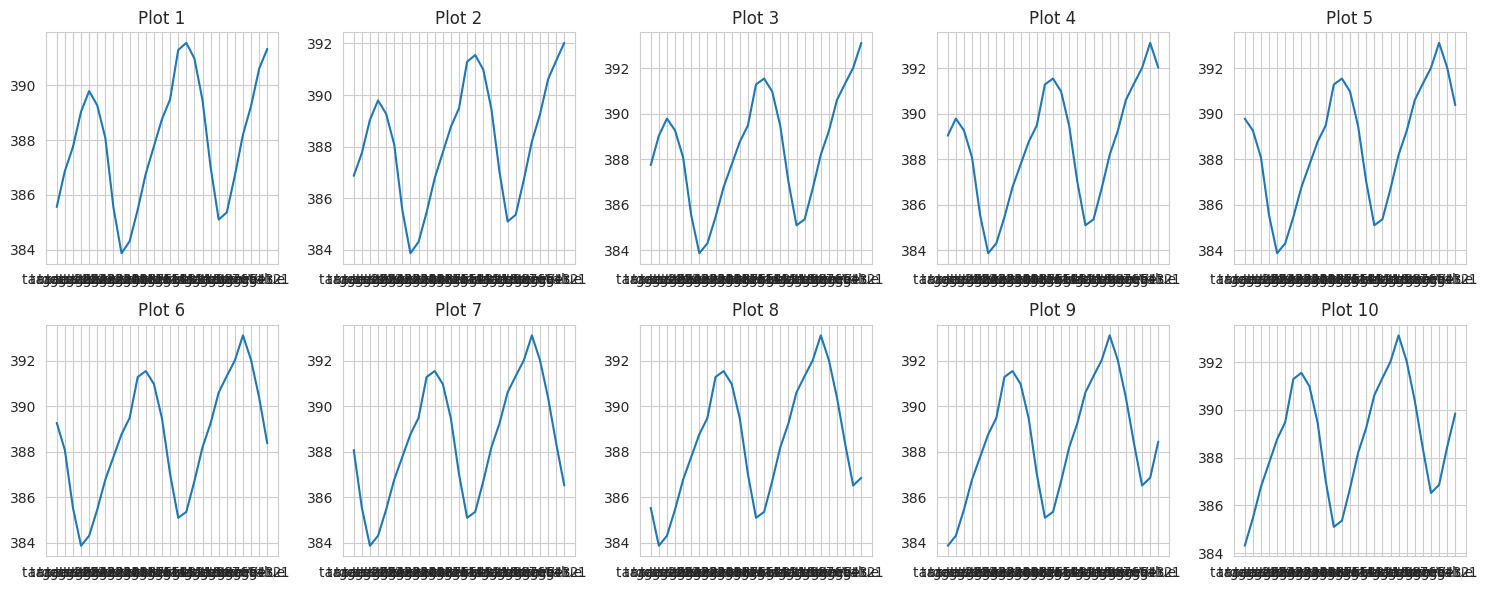

In [18]:
n,m = 2,5
fig, axes = plt.subplots(n, m, figsize=(15, 3*n))
on = n*m*9
print_data = train_3.loc[130:,:]
print(on)
count = 0
for i in range(n):  # Rows
    for j in range(m):  # Columns
        if count < n*m:
            axes[i, j].plot(print_data.iloc[count])
            axes[i, j].set_title(f'Plot {count+1}')
            count += 1

plt.tight_layout()
plt.show()

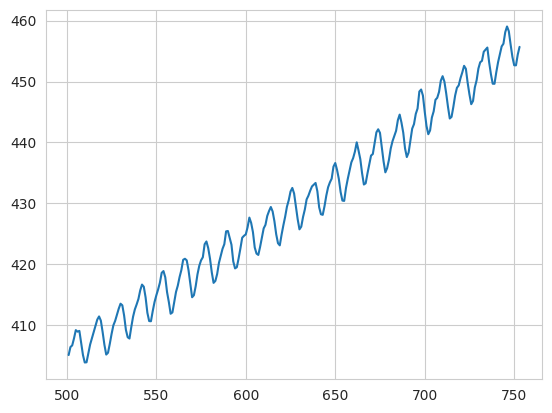

In [19]:
plt.plot(train_3.iloc[117:,-1])

In [20]:
len(train_3)//4

92

In [21]:
aug_n = train_3.iloc[len(train_3)//2:]
aug_n2 = train_3.iloc[len(train_3)//4:]
n = train_3['Value'].loc[746] - train_3['Value'].loc[735]
n

3.4600000000000364

In [22]:
aug_n
aug_n1 = aug_n.copy()
# aug_n2 = aug_n.copy()
aug_n3 = aug_n2.copy()

aug_n2 += n/2
aug_n3 += n

aug_n += n + n/2
aug_n1 += n*2


In [23]:
aug_data = pd.concat([train_3, aug_n2, aug_n3, aug_n, aug_n1], ignore_index=True)

In [24]:
aug_data .shape

(1296, 27)

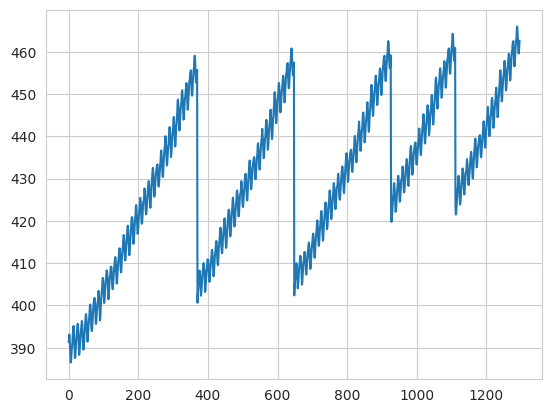

In [25]:
plt.plot(aug_data ['Value'].iloc[:])

In [ ]:
# aug_data

In [26]:
# n,m = 5,5
# fig, axes = plt.subplots(n, m, figsize=(15, 3*n))
# on = n*m*9
# print_data = aug_data .iloc[255:]

# print(on)
# count = 0
# for i in range(n):  # Rows
#     for j in range(m):  # Columns
#         if count < n*m:
#             axes[i, j].plot(print_data.iloc[count])

#             axes[i, j].set_title(f'Plot {count+1}')
#             count += 1

# plt.tight_layout()
# plt.show()

## normalise the data using z-Score
##### test_train2 -> z_train -> s_train

In [27]:
data = aug_data.to_numpy()
data =  data.astype(np.float64)
type(data)

numpy.ndarray

In [28]:
mean_value = data.mean()
std_value = data.std()

train_4 = (data - mean_value) / std_value

<Axes: >

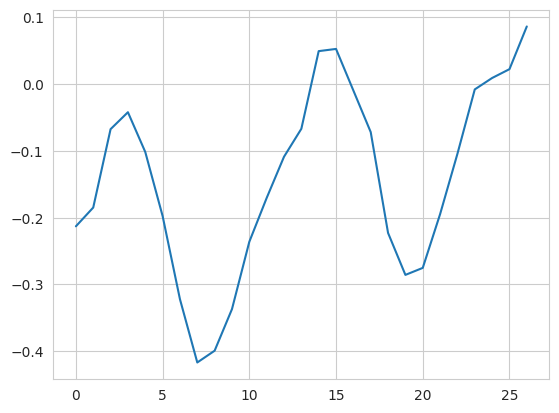

In [29]:
train_4 = pd.DataFrame(train_4)
train_4.iloc[773].plot()

## final  view at data

In [ ]:
# plt.figure(figsize=(24, 12))
# plt.plot(train_2, label='CO2 Levels', color='blue')
# plt.xlabel('Date')
# plt.ylabel('CO2 Levels (Normalized)')
# plt.title('CO2 Levels over Time')
# plt.legend()
# plt.show()

##### n_train -> data
##### data -> x,y

In [30]:
train_4 = np.array(train_4)
type(train_4)

numpy.ndarray

In [31]:
X = train_4[:,:-1]
x = X.reshape(X.shape[0], X.shape[1], 1)
y = train_4[:, -1]

In [32]:
x.shape, y.shape

((1296, 26, 1), (1296,))

### x,y -> x_train,y_train,  x_val,y_val

In [33]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
# x_train[target],y_train[target]

In [34]:
x_train.shape

(907, 26, 1)

In [35]:
target

26

In [36]:
model = Sequential([layers.Input((target, 1)),

                    LSTM(128,return_sequences=True),
                    LSTM(128,return_sequences=True),
                    LSTM(64),

                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),

                    Dense(1)])


model.compile(loss='mse', optimizer=Adam(learning_rate=0.001),metrics=['mse'])


early_stopping = EarlyStopping( monitor='val_mse',  patience=20,  verbose=1, restore_best_weights=True)

In [37]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, callbacks=[early_stopping],verbose=2 )

Epoch 1/200
29/29 - 15s - loss: 0.2314 - mse: 0.2314 - val_loss: 0.0303 - val_mse: 0.0303 - 15s/epoch - 501ms/step
Epoch 2/200
29/29 - 3s - loss: 0.0282 - mse: 0.0282 - val_loss: 0.0288 - val_mse: 0.0288 - 3s/epoch - 109ms/step
Epoch 3/200
29/29 - 3s - loss: 0.0267 - mse: 0.0267 - val_loss: 0.0214 - val_mse: 0.0214 - 3s/epoch - 106ms/step
Epoch 4/200
29/29 - 3s - loss: 0.0230 - mse: 0.0230 - val_loss: 0.0227 - val_mse: 0.0227 - 3s/epoch - 106ms/step
Epoch 5/200
29/29 - 5s - loss: 0.0258 - mse: 0.0258 - val_loss: 0.0210 - val_mse: 0.0210 - 5s/epoch - 168ms/step
Epoch 6/200
29/29 - 3s - loss: 0.0224 - mse: 0.0224 - val_loss: 0.0199 - val_mse: 0.0199 - 3s/epoch - 103ms/step
Epoch 7/200
29/29 - 3s - loss: 0.0219 - mse: 0.0219 - val_loss: 0.0190 - val_mse: 0.0190 - 3s/epoch - 107ms/step
Epoch 8/200
29/29 - 3s - loss: 0.0216 - mse: 0.0216 - val_loss: 0.0202 - val_mse: 0.0202 - 3s/epoch - 99ms/step
Epoch 9/200
29/29 - 6s - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0241 - val_mse: 0.0241 - 6s/e

In [ ]:
# #attentinon model

# import tensorflow as tf
# from keras.models import Model
# from keras.layers import LSTM, Dense, MultiHeadAttention, Input, Concatenate

# num_heads = 2
# attention_dim = 64


# query_input = Input(shape=(target, 1))
# key_input = Input(shape=(target, 1))
# value_input = Input(shape=(target, 1))


# query_projection = Dense(attention_dim)(query_input)
# key_projection = Dense(attention_dim)(key_input)
# value_projection = Dense(attention_dim)(value_input)

# concatenated_attention = Concatenate(axis=-1)([query_projection, key_projection, value_projection])

# lstm1 = LSTM(128, return_sequences=True)(concatenated_attention)
# lstm2 = LSTM(64, return_sequences=True)(lstm1)

# dense1 = Dense(64, activation='relu')(lstm2)
# dense2 = Dense(32, activation='relu')(dense1)

# attention_layer = MultiHeadAttention(num_heads=num_heads, key_dim=attention_dim)(query=query_input, key=key_input, value=value_input)

# concatenated_output = Concatenate(axis=-1)([dense2, attention_layer])

# output = Dense(1)(concatenated_output)


# model = Model(inputs=[query_input, key_input, value_input], outputs=output)
# model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mse'])

# #early_stopping = EarlyStopping(monitor='val_mse', patience=10, verbose=1, restore_best_weights=True)

# history = model.fit([x_train, x_train, x_train], y_train, validation_data=([x_val, x_val, x_val], y_val), epochs=100, verbose=2)

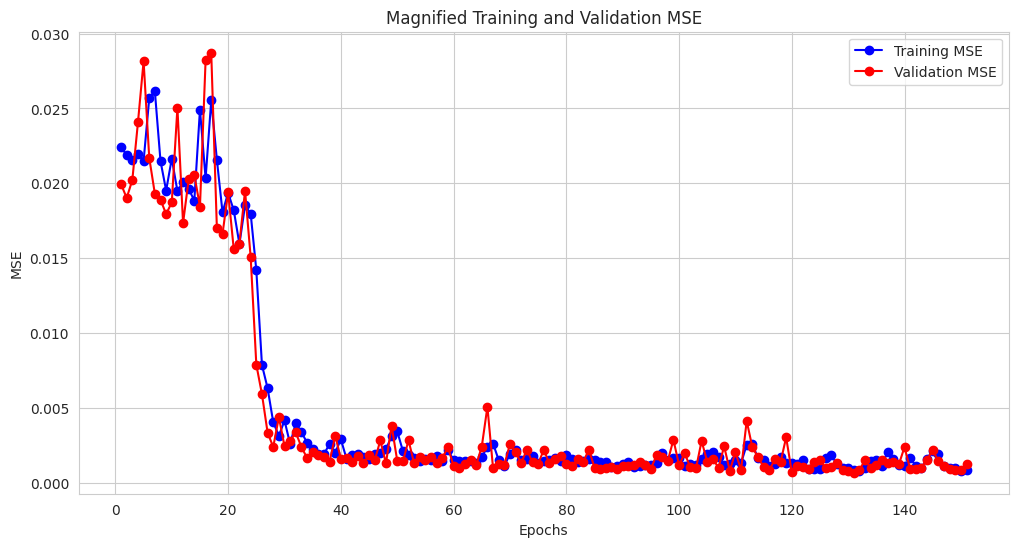

In [38]:
mse = history.history['mse']
val_mse = history.history['val_mse']
mse = mse[5:]
val_mse = val_mse[5:]

# Create a plot
epochs = range(1, len(mse) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs, mse, 'bo-', label='Training MSE')
plt.plot(epochs, val_mse, 'ro-', label='Validation MSE')

plt.title('Magnified Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

## predict new values

In [41]:
pred_x = list(train_3.iloc[-1])
pred_x = np.array(pred_x)
pred_x = pred_x[1:]

pred_x = pred_x.astype(np.float64)
pred_x = (pred_x - mean_value) / std_value
pred_x = pred_x.reshape(1, len(pred_x), 1)
# print(pred_x)


In [ ]:
#
# pred_x = []
# for i in range(target-1):
#   pred_x.append(x[-1][i].item())
# pred_x.append(y[-1])
# pred_x = np.array(pred_x)
# pred_x = pred_x.astype(np.float64)
# pred_x = pred_x.reshape(1, len(pred_x), 1)
# pred_x

In [ ]:
# ready = model.predict(pred_x)
# ready

1/1 [==============================] - 1s 796ms/step


array([[1.6318544]], dtype=float32)

In [42]:
result =[]
for i in range(len(test_2)):

  ready = model.predict(pred_x)
  ready = ready.item()
  result.append(ready)

  # for i in range(target-1,0,-1):
  #   pred_x[0][i] = pred_x[0][i - 1]

  # pred_x[0][0] = ready

  pred_x = np.append(pred_x, ready)
  pred_x = pred_x[1:]
  pred_x = pred_x.reshape(1, len(pred_x), 1)

  # print(pred_x)

1/1 [==============================] - 0s 32ms/step


In [43]:
len(result) ### 24

24

In [44]:
result_z = pd.DataFrame(result)
a = (train_3 - mean_value) / std_value
new_value = pd.concat([a['Value'], result_z ], axis=0, ignore_index=True)

In [ ]:
len(train_3)

370

In [ ]:
len(new_value)

394

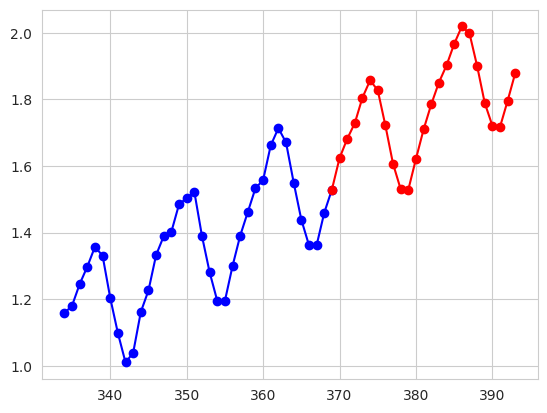

In [45]:
new_value = pd.DataFrame(new_value)
plt.plot(new_value.iloc[len(new_value)-60:len(new_value)-24,:],'-bo')
plt.plot(new_value.iloc[len(new_value)-24 -1 :,:],'-ro')

In [46]:
test_2['Label'] =  result_z
test_2

,id,Label
0,0,1.623423
1,1,1.681091
2,2,1.728641
3,3,1.805180
4,4,1.857082
5,5,1.827570
6,6,1.721698
7,7,1.606733
8,8,1.530434
9,9,1.528594


In [47]:
test_2['Label'] = (test_2['Label'] * std_value) + mean_value

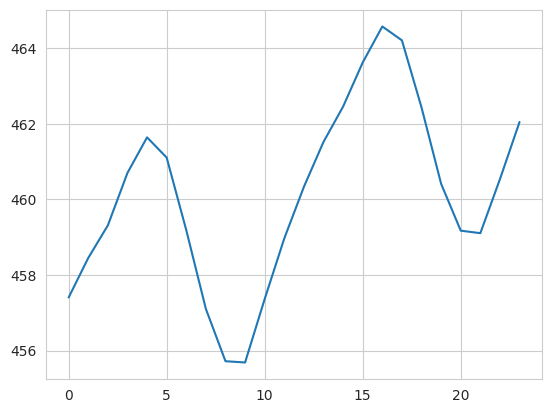

In [48]:
plt.plot(test_2['Label'])

In [49]:
test_2['Label'][0]

457.4049641251645

In [50]:
test_2.to_csv('predictions.csv',index=False)
#result.to_csv('/content/drive/MyDrive/Player Transfer Value/final_Predictions_0.29.csv',index=False)